In [1]:
from os import path
import pandas as pd

import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.stats import norm
import itertools

import matplotlib.pyplot as plt

# Projeto Final de Modelagem Matemática: Epidemiologia

- **Alunos: Guilherme Monteiro, Jackeline Carvalho e Jean Sette**
- **Data de entrega: 8 de Julho**

## Introdução

### Modelo SIR em rede de sítios

#### Representação do sistema

Nesse caso, consideramos 

- $m$ **sítios**.

- Em cada sítio, uma **população total** $N_i$, com um número $S_i$ de **suscetíveis**, $I_i$ de **infectados** e $R_i$ de **recuperados**, $i=1, \ldots, m$.

- Sem vitalidade, de forma que $S_i + I_i + R_i = N_i$ é constante, para cada $i=1, \ldots, m$.

#### Dinâmica

- Denominamos por **um ciclo** cada unidade de tempo, digamos um dia.

- O **ciclo** possui uma fase **ativa**, onde a infeção pode ocorrer, e uma fase **inativa**, onde não há transmissão da infecção.

- Na fase **ativa** de cada ciclo, uma **fração** $\phi_{ij}$ da população $N_i$ migra **do sítio $i$ para o sítio $j$**, voltando ao sítio $i$ na fase **inativa**.

- Naturalmente, $0\leq \phi_{ij} \leq 1$, para cada $i,j=1, \ldots, m$, e $\sum_{j=1}^m\phi_{ij} = 1$, para cada $i=1,\ldots, m$.

- Em cada sítio $j=1, \ldots, m$, os indivíduos **suscetíveis** que lá se encontram podem se tornar **infectados** ao encontrar um indivíduo infectado no mesmo sítio, com um **fator de transmissão** $\beta_j$ característico do sítio $j$ em que se encontram.

- Os indivíduos **infectados** de cada sítio, podem se recuperar com um **fator de recuperação** $\gamma_i$, característico do ambiente e dos indivíduos que habitam o sítio.

#### Sistema de equações diferenciais

Temos o sistema

$$
\begin{cases}
  \displaystyle \frac{\rm d S_i}{\rm d t} = - \sum_{j=1}^m \sum_{k=1}^m \beta_j\phi_{kj}\phi_{ij}\frac{I_k}{\tilde N_j}S_i, & i = 1, \ldots, m, \\
  \displaystyle \frac{\rm d I_i}{\rm d t} = \sum_{j=1}^m \sum_{k=1}^m \beta_j\phi_{kj}\phi_{ij}\frac{I_k}{\tilde N_j}S_i - \gamma_i I_i, & i = 1, \ldots, m, \\
  \displaystyle \frac{\rm d R_i}{\rm d t} = \gamma_i I_i, & i = 1, \ldots, m,
\end{cases}
$$

onde

$$ \tilde N_j = \sum_{i=1}^n \phi_{ij}N_i, \qquad j = 1, \ldots, m,
$$

é a população existente no sítio $j$ durante a fase ativa do ciclo.

### Redução do sistema

Como no caso do modelo SIR clássico, podemos reduzir o sistema a um subsistema envolvendo apenas **suscetíveis** e **infectados**, considerando que a população total é constante.

Temos 

$$ R_i = N_i - S_i - I_i
$$

e basta consideramos

$$
\begin{cases}
  \displaystyle \frac{\rm d S_i}{\rm d t} = - \sum_{j=1}^m \sum_{k=1}^m \beta_j\phi_{kj}\phi_{ij}\frac{I_k}{\tilde N_j}S_i, & i = 1, \ldots, m, \\
  \displaystyle \frac{\rm d I_i}{\rm d t} = \sum_{j=1}^m \sum_{k=1}^m \beta_j\phi_{kj}\phi_{ij}\frac{I_k}{\tilde N_j}S_i - \gamma_i I_i, & i = 1, \ldots, m,
\end{cases}
$$

onde

$$ \tilde N_j = \sum_{i=1}^n \phi_{ij}N_i, \qquad j=1, \ldots, m,
$$

são constantes.

### Representação vetorial

Considerando os estados na forma de vetores, $ S=(S_1, \ldots, S_m), \qquad I = (I_1, \ldots, I_m)$, podemos escrever as equações na forma vetorial

$$
\begin{cases}
  \displaystyle \frac{\rm d S}{\rm d t} = - \rm{diag}(AI)S, \\
  \displaystyle \frac{\rm d I}{\rm d t} = \rm{diag}(AI)S - \Gamma I,
\end{cases}
$$

onde 
- $\Gamma$ é a matriz diagonal $\Gamma = \rm{diag}(\gamma_1, \ldots, \gamma_m)$, 
- $A$ é a matriz

$$ A = \left(\sum_{j=1}^m\frac{\beta_j\phi_{kj}\phi_{ij}}{\tilde N_j}\right)_{ik}
$$

- $\rm{diag}(AI)$ é a matriz diagonal formada pelo vetor obtido da aplicação da matriz $A$ ao vetor $I$,

$$ AI = \left(\sum_{k=1}^m\sum_{j=1}^m\frac{\beta_j\phi_{kj}\phi_{ij}}{\tilde N_j} I_k\right)_i
$$

## Objetivo

O objetivo deste projeto é propor um **modelo em rede** adequado que descreva evolução dos casos de dengue na cidade do Rio de Janeiro, com cada vértice representando uma das regiões. Para isso, é necessário que os parâmetros do modelo sejam devidamente ajustados aos dados fornecidos pela prefeitura, na página Rio Prefeitura – Dengue: dados epidemiológicos, onde estão disponíveis os dados entre 2000 e 2019.


## Procedimentos e Resultados

Devido a dificuldade de encontrar dados numéricos de mobilidade urbana entre os bairros da cidade do rio de janeiro, o trabalho teve como base um artigo científico que fez uma boa modelagem para a epidemia de dengue, que ocorreu entre o final de 2007 e o final de 2008, em alguns poucos bairros do Rio de Janeiro. Mas, além de reproduzir os resultados do autor até certo ponto, expandimos a modelagem para a cidade inteira, agrupando os bairros em macroregiões (na qual conseguimos alguns dados de mobilidade), para uma posterior comparação dos parâmetros encontrados. 

Além disso, é importante ressaltar que devido ao risco da otimização dos parâmtros se basear em mínimos locais da função erro escolhida, utilizamos um gride com diversos chutes iniciais para poder então pegar o que gera o menor valor para rodar nossa função de otimização. Diante disso, limitações computacionais nos fez criar hipóteses a partir de algumas suposições, mesmo tentando evitar, sobre alguns dos parâmtros deconhecidos para assim então conseguirmos estimar os que menos tinhamos idéias sobre. 

Apesar da proposta original do projeto ser considerar, em particular os períodos de 10 de outubro de 2007 a 3 de dezembro de 2008 e de novembro de 2015 a outubro de 2016, escolhemos manter o período analisado no artigo, que coincide com o primeiro dos períodos propostos, uma vez que é nesse intervalo de tempo que houve um surto maior de dengue que então possibilitou uma melhor análise, enquanto que nos anos posteriores os incidentes não tiveram um bom comportamento impossibilitando uma boa modelagem. 

Agora serão listados os procedimentos passo a passo:

1. **Importando os dados:**

     Primeiramente carregamos os dados da planilha obtida a partir dos dados informados pela prefeitura no período de **de outubro de 2007 a 3 de dezembro de 2008** e colocarmos em um formato adequado para trabalharmos.

In [2]:
dengue2007 = pd.read_excel(pd.ExcelFile('dengue2007.xls'), header=[0,1])
dengue2008 = pd.read_excel(pd.ExcelFile('dengue2008.xls'), header=[0,1])


meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 
         'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

def StringToFloat(string):
    '''Conserta os valores que não foram
    traduzidos do arquivo como float'''
    lista = list(string)
    NovaLista = [x for x in lista if x != ' ']
    
    NovaString = NovaLista[0]
    for x in NovaLista[1:]: NovaString+=x
        
    numero = float(NovaString)
    return numero

def concatenaPeriodo(Ant, Pos): 
    '''Apos criar uma matriz para cada ano, juntamos
    ambas para formar apenas um periodo mais longo'''
    Matriz = Ant
    Matriz2 = Pos
    for x in Matriz2:
        Matriz.append(x)

    Matriz_Casos = np.array(Matriz).T
    return Matriz_Casos

2. **Escolha das Regiões Alvo e definição da matriz de mobilidade:** 

    Na segunda etapa, após extraírmos os dados, selecionamos os bairros escolhidos no artigo que são: **Centro, Botafogo, Copacabana, Lagoa, Barra da Tijuca e Rocinha**. O critério utilizado foi que formavam um conjunto de regiões bem representativo da cidade, uma vez que era composto de quatro das regiões mais saudáveis do país que são Botafogo ($n_{1}$), Copacabana ($n_{2}$), Lagoa ($n_{3}$) e Barra da Tijuca ( $n_{4}$); A parte central (C) do Rio, onde muitas pessoas vão trabalhar todos os dias; E uma enorme favela (F) chamada Rocinha, situada próximo às demais regiões. Características essas que nos possibilitou uma estimitavia mais pontual sobre as mobilidades entre essas áreas. 
    
    Tendo em vista essas regiões, a criação da matriz de mobilidade não foi uma tarefa difícil, uma vez que leva em conta a estrutura social de C, $n_{1}$, $n_{2}$, $n_{3}$, $n_{4}$ e F. Foi utilizado apenas 3 parâmetros $\phi_{0}$, $\phi_{1}$ e $\phi_{2}$ para descrever a matriz de fluxo. O primeiro representa as frações de movimento entre as vizinhanças $n_{1}$, $n_{2}$, $n_{3}$ e $n_{4}$. O segundo representa a fração de movimento entre qualquer vértice e C. E o terceiro representa o fluxa da favela para as demais vizinhanças. Portanto, teremos uma matriz de fluxo $\phi_{6x6}$ que levará em consideração o seguinte:
            
    - As pessoas que vivem em $n_{1}$, $n_{2}$, $n_{3}$ e $n_{4}$ geralmente trabalham nessas regiões ou no centro (C).
    - As pessoas que vivem na favela (F) podem trabalhar no centro (C) ou em $n_{1}$, $n_{2}$, $n_{3}$ e $n_{4}$. Por outro    lado, pouquíssimas pessoas vêm de qualquer outro bairro para trabalhar em F, então definimos esse elemento de $\phi_{6x6}$ para zero.
    - As pessoas que moram no centro da cidade (C), em média, raramente deixam de trabalhar em outros bairros.
    - Por simplicidade, assumiremos que os bairros residenciais $n_{1}$, $n_{2}$, $n_{3}$ e $n_{4}$ estão igualmente conectados.
    - O fluxo de pessoas que vão trabalhar nas zonas $n_{1}$, $n_{2}$, $n_{3}$ e $n_{4}$ partindo da favela (C) é diferente do fluxo entre os moradores dessas próprias áreas.
    - Não sabemos os valores dos parâmetros de fração $\phi_{0}$, $\phi_{1}$ e $\phi_{2}$. Assim, a partir de levantamentos feitos na internet concordavam que porcentagem de cada vértice que sai de casa para trabalhar em outros lugares é entre 20 e 30 por cento. Portanto, vamos corrigir esses parâmetros no conjunto {0,05, 0,07}, em particular faremos $\phi_{0} = 0.05$, $\phi_{1} = 0.07$ e $\phi_{2} = 0.05$.
    
    Assim, a matriz de fluxo pode ser escrito como   
    
        
$$    
\begin{array}{cccccccc}
\qquad &
\text{C}&
n_{1}&
n_{2}&
n_{3}&
n_{4}&
\text{F}\\
\end{array}
$$
$$
\phi_{6x6} =
\begin{array}{c}
\text{C}\\
n_{1}\\
n_{2}\\
n_{3}\\
n_{4}\\
\text{F}\\
\end{array}
\left [
\begin{array}{cccccc}
1 & 0 & 0 & 0 & 0 & 0 \\
\phi_{1} & \phi_{3} & \phi_{0} & \phi_{0} & \phi_{0} & 0 \\
\phi_{1} & \phi_{0} & \phi_{3} & \phi_{0} & \phi_{0} & 0 \\
\phi_{1} & \phi_{0} & \phi_{0} & \phi_{3} & \phi_{0} & 0 \\
\phi_{1} & \phi_{0} & \phi_{0} & \phi_{0} & \phi_{3} & 0 \\
\phi_{1} & \phi_{2} & \phi_{2} & \phi_{2} & \phi_{2} & \phi_{4} \\
\end{array}
\right]
$$


   Pela conservação da fração de movimento, devemos ter $\phi_{3}$ = 1 - $\phi_{1}$ - 3$\phi_{0}$ e $\phi_{4}$ = 1 - $\phi_{1}$ - 4$\phi_{2}$
   

In [3]:
areasAlvo = ['II CENTRO', 'IV BOTAFOGO', 'V COPACABANA', 'VI LAGOA',
             'BARRA DA TIJUCA', 'XXVII ROCINHA']

def criaMatrizCasos(dataframe, inicio=0, fim=12, primeira_analise = True):
    '''Cria a matriz transposta da que representa
    as areas alvo como linhas e as semanas como coluna,
    os valores aij sao o numero de casos'''
    
    if primeira_analise:        
        relacao = []

        for area in areasAlvo:
            relacao.append(np.where(np.matrix(dataframe).T[0] == area)[1][0])
    else: relacao = list(range(9))
    
    Matriz = []
    for x in meses[inicio:fim]:
        for y in dataframe[x]:
            if y == 'Total de Casos':
                continue
            
            Vetor = []
            for z in relacao:
                casos = dataframe[x][y][z]
                if type(casos) == str:
                    casos = StringToFloat(casos)
                Vetor.append(casos)
            Matriz.append(Vetor)
    
    return Matriz

M1 = criaMatrizCasos(dengue2007, inicio=9)
M2 = criaMatrizCasos(dengue2008)

Casos = concatenaPeriodo(M1,M2)
Casos_reserva = np.copy(Casos)

dengue2007matriz = np.matrix(dengue2007)
poptotal = dengue2007matriz[:, 1]
areas = dengue2007matriz[:,0].squeeze()
N = np.array([])
for area in areasAlvo:
    N = np.append(N, poptotal[np.where(areas == area)[1][0]])
N = N.astype(float)

In [4]:
def criarϕ(ϕ0, ϕ1, ϕ2):
    ϕ3 = 1 - ϕ1 - 3*ϕ0
    ϕ4 = 1 - ϕ1 - 4*ϕ2
    return np.array([[1.0, 0, 0, 0, 0, 0],
            [ϕ1, ϕ3, ϕ0, ϕ0, ϕ0, 0],
            [ϕ1, ϕ0, ϕ3, ϕ0, ϕ0, 0],
            [ϕ1, ϕ0, ϕ0, ϕ3, ϕ0, 0],
            [ϕ1, ϕ0, ϕ0, ϕ0, ϕ3, 0],
            [ϕ1, ϕ2, ϕ2, ϕ2, ϕ2, ϕ4]])

ϕ = criarϕ(0.05, 0.07, 0.05)
Np = np.array([np.dot(ϕ[:, i], N) for i in range(6)])

3. **Parâmetros Epidemiológicos e hipóteses dos dados:** 

    Vamos assumir que todos os bairros residenciais têm a mesma taxa de infecção $\beta_{0}$. Esta hipótese baseia-se no fato de que tanto a população local quanto o governo estão igualmente preocupados em evitar a água estagnada em lugares privados e públicos. De fato, o controle da proliferação do mosquito Aedes aegypti é influenciado pela forma como a população local armazena sua água e pelas políticas locais de saúde. Assim, supõe-se, por exemplo, que as pessoas (residentes e governo) em n1, n2, n3 e n4 estão igualmente preocupadas com isso. Também definimos os fatores adimensionais $\theta_{C}$ e $\theta_{F}$ de forma que $$ \beta_{C} = \theta_{C}\beta_{0}\quad\text{e}\quad\beta_{F} = \theta_{F}\beta_{0} $$
    Entretanto, trataremos posteriormente a taxa de infecção como uma variável temporal, o que condiz mais com a realidade.
    
    Sobre a taxa de recuperação $\gamma$, sabe-se que o período infeccioso médio para a dengue é de cerca de 4 ou 5 dias. E para o modelo SIR em rede, esse período é dado por $\frac{1}{\gamma}$. Como nossa escala está em semanas, podemos concluir que $\gamma$ = $\frac{7}{5}$ ~ $\frac{7}{4}$ = [1.4; 1.75].
    
    Precisamos ainda levar em conta que o número de casos registrados difere consideravelmente do número real de pessoas portadoras do vírus. Devemos considerar os casos assintomáticos, os quais são, na verdade, a maioria para a dengue. Além disso, devido a precariedade da saúde pública no Rio de Janeiro, podemos ainda supor que um bom número de pessoas não procurou um médico quando começou a apresentar sintomas. Para mitigar o problema, aplicamos uma contante multiplicativa sobre nossos dados, de modo que os números de casos que iremos levar em conta é $K$ vezes (para $K>1$) o número de casos. Entretanto, testaremos um valor fixo $K = 10$ e depois seguiremos com um valor que se ajuste aos dados.

In [5]:
def criarP(β):
    return ϕ @ (np.diag(β/Np)@ϕ).T

def dividir_linhas(matriz, array_divisor):
    ans = np.copy(matriz)
    for i, divisor in enumerate(array_divisor):
        ans[i] = ans[i]/divisor
    return ans

Fitaremos então os parâmetros $\beta_0, \theta_C, \theta_F$ e $\gamma$, onde $\theta_C$ e $\theta_F$ são tais que $\beta_C = \theta_C \beta_0$ e $\beta_F = \theta_F \beta_0$.<br>

Agora, sobre como tal otimização será feita.

Primeiro, criamos uma função `erro`, a qual dado os parâmetros, retorna a divergência entre a solução do sistema de ODEs sob esses parâmetros (usando o `odeint` do `scipy.integrate`) e os dados que temos (planilha vezes $K$). Essa divergência é calculada da seguinte forma:
$$\left\lVert\frac{S_i - \mathrm{Dados}_i}{\mathrm{mediana}(\mathrm{Dados}_i)}\right\Vert_F.$$
Dividimos pela mediana de cada uma das séries para que nosso algoritmo de otimização não priorize fitar melhor uma área com mais casos em detrimento de algum com menos casos. Sem essa "normalização" poderíamos ter curvas precisas para determinadas áreas com muitos casos e curvas completamente divergentes para outras com um número menor de casos, desde que tais curvas também não atingissem valores altos. Isso porque, nesse caso, as regiões do primeiro caso seriam as de maior "impacto" na norma de Frobenius e as do segundo, nem tanto.

In [6]:
tf = Casos.shape[1] - 1
k = 2 #controla o tamanho do passo para integração
ts_continuo = np.arange(0, tf + 1/2**k, 1/2**k) #"contínuo"
No_int = len(ts_continuo)
print(f'Número de pontos utlizados na integração: {No_int}')
pts_discretos = np.array([0])
while pts_discretos[-1] < No_int-1:
    pts_discretos = np.append(pts_discretos, [pts_discretos[-1] + 2**k])

Casos = 10*Casos_reserva.copy()
def dSI_dt(SI, t, P, γ):
    S, I = SI[:6], SI[6:]
    L = np.diag(P@I) @ S
    return np.append(-L, L-γ*I)

def erro(parametros, retornar_resultado = False):
    β0, θC, θF, γ = parametros
    β = np.array([θC*β0, β0, β0, β0, β0, θF*β0])
    P = criarP(β)
    sol = odeint(dSI_dt, np.append(N - Casos[:, 0], Casos[:,0]), ts_continuo, args = (P, γ))
    S = np.array([sol[:,i] for i in range(6, 12)])
    
    ans = np.linalg.norm(dividir_linhas(S[:, pts_discretos]\
                         - Casos, np.median(Casos, axis=1)), ord = 'fro')
    if retornar_resultado:
        ans = (ans, S)
    return ans

Número de pontos utlizados na integração: 257


Formamos ainda uma "malha" em intervalos onde cremos que os parâmetros devem estar. A combinação de parâmetros que leva ao menor erro é usada como chute inicial para a função `minimize` do `scipy.optimize`, a qual fará a otimização da função erro. 

In [7]:
malha_de_parametros = [[0.1+((5-0.1)/4)*i for i in range(5)]] + [[(3/2)*i for i in range(3)]]*2 \
                      + [[1.4+((1.75-1.4)/2)*i for i in range(3)]]
def encontrar_chute(erro, malha_de_parametros):
    parametros_possiveis = list(itertools.product(*malha_de_parametros))
    erros = [erro(parametros) for parametros in parametros_possiveis]
    return parametros_possiveis[np.argmin(erros)]
chute = encontrar_chute(erro, malha_de_parametros)
melhor_fit = minimize(erro, chute, bounds = [[0,np.inf], [0,np.inf], [0,np.inf], [1.4, 1.75]]).x

Enfim, plotamos os resultados.

β0 = 0.9155601734052781
θC = 4.453564157152794
θF = 1.9209002298259266
γ = 1.4
erro = 112.56272287539039


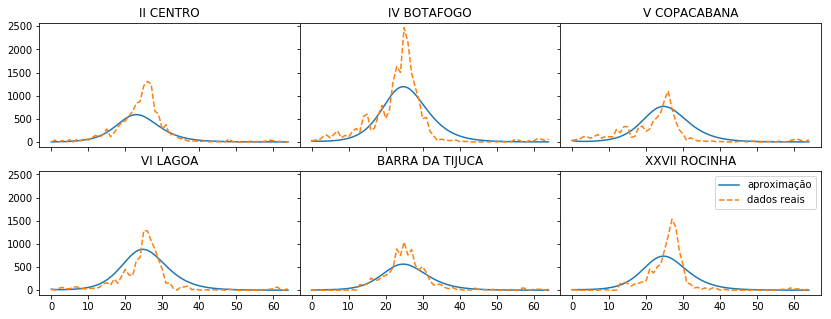

In [8]:
def exibir_resultados(erro, melhor_fit, Casos, str_parametros):
    for i, parametro in enumerate(str_parametros):
        print(f'{parametro} = {melhor_fit[i]}')

    divergencia, S = erro(melhor_fit, retornar_resultado = True)
    print(f'erro = {divergencia}')
    limcima = max(np.max(S), np.max(Casos))+100

    fig, axs = plt.subplots(2,3, sharex='col', sharey='row',
                            gridspec_kw={'wspace': 0},
                            figsize = (14, 5))
    axs = np.matrix(axs).A1

    for i, area in enumerate(areasAlvo):
        axs[i].plot(ts_continuo, S[i], label = "aproximação")
        axs[i].plot(Casos[i], '--', label = "dados reais")
        axs[i].set_title(area)
        axs[i].set_ylim((-100, limcima))
    plt.legend()
    plt.show()
exibir_resultados(erro, melhor_fit, Casos, ["β0", "θC", "θF", "γ"])

Agora vamos considerar $K$ como parâmetro e fitá-lo.

β0 = 0.523225241160131
θC = 9.96360929447894
θF = 3.4067894459196393
γ = 1.7201708649910612
K = 3.8394542390928743
erro = 96.81677602577706


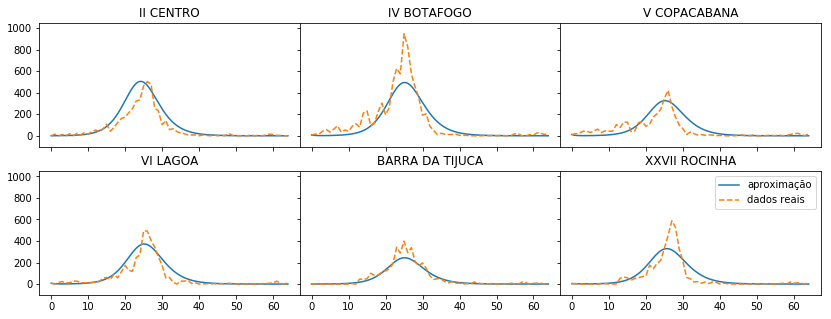

In [9]:
Casos = Casos_reserva.copy()
def erro(parametros, retornar_resultado = False):
    β0, θC, θF, γ, K = parametros
    β = np.array([θC*β0, β0, β0, β0, β0, θF*β0])
    P = criarP(β)
    sol = odeint(dSI_dt, np.append(N - K*Casos[:, 0], K*Casos[:,0]), ts_continuo, args = (P, γ))
    S = np.array([sol[:,i] for i in range(6, 12)])
    
    ans = np.linalg.norm(dividir_linhas(S[:, pts_discretos]\
                          - K*Casos, np.median(K*Casos, axis=1)), ord = 'fro')
    
    if retornar_resultado:
        ans = (ans, S)
    return ans

malha_de_parametros = [[0.1+((5-0.1)/4)*i for i in range(5)]] + [[(3/2)*i for i in range(3)]]*2 \
                      + [[1.4+((1.75-1.4)/2)*i for i in range(3)]] + [[5, 10, 15, 20]]
chute = encontrar_chute(erro, malha_de_parametros)
melhor_fit = minimize(erro, chute, bounds = [[0,np.inf], [0,np.inf], [0,np.inf], [1.4, 1.75], [1, 50]]).x
K = melhor_fit[-1]

exibir_resultados(erro, melhor_fit, K*Casos, ["β0", "θC", "θF", "γ", "K"])

Estaremos trabalhando com o $K$ que fitamos daqui em diante. Ademais, todos os outros parâmetros que encontramos nessa última célula permanecerão fixos e seguiremos uma abordagem sequencial para a otimização de parâmetros a partir desse ponto.

In [10]:
Casos = K*Casos_reserva.copy()
β0, θC, θF, γ, _ = melhor_fit

Retornamos à matriz $\phi$. Tentaremos fitar os parâmetros $\phi_0$, $\phi_1$ e $\phi_2$ que a definem.

/home/guilherme/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/guilherme/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


ϕ0 = 0.2511318067444422
ϕ1 = 0.0700786398503363
ϕ2 = 0.050417826295704536
erro = 96.65580892208011


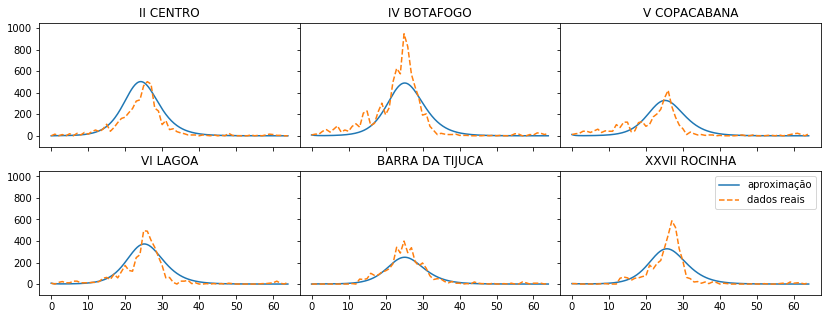

In [11]:
β = np.array([θC*β0, β0, β0, β0, β0, θF*β0])

def criarP(β, ϕ):
    Np = np.array([np.dot(ϕ[:, i], N) for i in range(6)])
    return ϕ @ (np.diag(β/Np)@ϕ).T

def erro(parametros, retornar_resultado = False):
    ϕ0, ϕ1, ϕ2 = parametros
    ϕ = criarϕ(ϕ0, ϕ1, ϕ2)
    P = criarP(β, ϕ)
    sol = odeint(dSI_dt, np.append(N - Casos[:, 0], Casos[:,0]), ts_continuo, args = (P, γ))
    S = np.array([sol[:,i] for i in range(6, 12)])
    
    ans = np.linalg.norm(dividir_linhas(S[:, pts_discretos]\
                          - Casos, np.median(Casos, axis=1)), ord = 'fro')
    
    if retornar_resultado:
        ans = (ans, S)
    return ans

parametros_possiveis = []
malha = np.linspace(0, 1, 40)
for ϕ1 in malha:
    for ϕ0 in malha[np.where(malha<(1-ϕ1)/3)]:
        for ϕ2 in malha[np.where(malha<(1-ϕ1)/4)]:
            parametros_possiveis += [[ϕ0, ϕ1, ϕ2]]
erros = [erro(parametros) for parametros in parametros_possiveis] 
chute = parametros_possiveis[np.argmin(erros)]
melhor_fit = minimize(erro, chute).x
for parametro in melhor_fit: assert 0<=parametro
assert 3*melhor_fit[0] + melhor_fit[1]<=1
assert 4*melhor_fit[2] + melhor_fit[1]<=1

exibir_resultados(erro, melhor_fit, Casos, ["ϕ0", "ϕ1", "ϕ2"])

In [12]:
ϕ = criarϕ(*melhor_fit)

Pensamos agora em modificar as taxas de infecção, modelando-as por uma gaussiana em função do tempo, pois sabemos que os casos de dengue são mais elevados em um período específico do ano que nos outros:
$$\beta_0(t) = g + h\mathcal{N}(t|\mu, \sigma)$$
Faremos $\beta_C(t) = \theta_C  h\mathcal{N}(t|\mu, \sigma)$ e $\beta_F(t) = \theta_F  h\mathcal{N}(t|\mu, \sigma)$, onde $\theta_C$ e $\theta_F$ são os parâmetros que encontramos quando fitamos $\beta_0$ constante.

g = 0.44002989383884955
h = 20.13601306149154
μ = 16.484599926004687
σ = 15.825072103729292
erro = 76.1452953186495


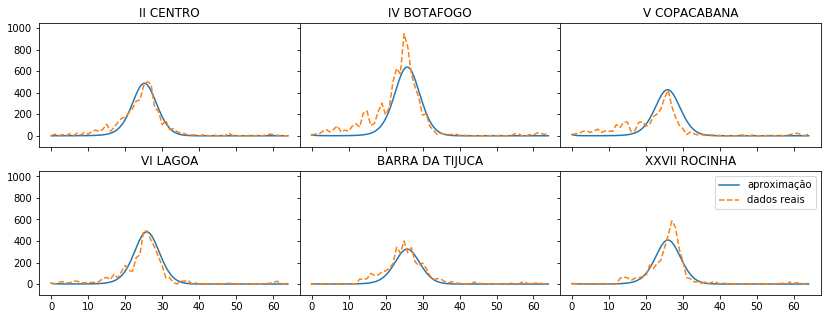

In [13]:
Np = np.array([np.dot(ϕ[:, i], N) for i in range(6)])
ϕ_ = ϕ @ ϕ.T @ np.diag(1/Np)
altura_max = np.max(Casos)

def dSI_dt(SI, t, g, h, μ, σ):
    gaussiana = h*norm.pdf(t, μ, σ)
    β0 = g + gaussiana
    βC = g + θC*gaussiana
    βF = g + θF*gaussiana
    β = np.array([βC, β0, β0, β0, β0, βF])
    S, I = SI[:6], SI[6:]
    L = np.diag(ϕ_@np.diag(β)@I) @ S
    return np.append(-L, L-γ*I)
    
def erro(parametros, retornar_resultado = False):
    sol = odeint(dSI_dt, np.append(N - Casos[:, 0], Casos[:,0]), ts_continuo, args = tuple(parametros))
    S = np.array([sol[:,i] for i in range(6, 12)])
    
    ans = np.linalg.norm(dividir_linhas(S[:, pts_discretos]\
                          - Casos, np.median(Casos, axis=1)), ord = 'fro')
    
    if retornar_resultado:
        ans = (ans, S)
    return ans

malha_de_parametros = [[0, 0.5, 1],
                       [1 + (5-1)*i/3 for i in range(4)],
                       [tf*i/(2*4) for i in range(5)],
                       [1 + (tf-1)*i/3 for i in range(4)]]
chute = encontrar_chute(erro, malha_de_parametros)
melhor_fit = minimize(erro, chute).x
exibir_resultados(erro, melhor_fit, Casos, ["g", "h", "μ", "σ"])

4. **Abrangendo toda a cidade do rio de Janeiro:** 
    
    Tomando como base um outro artigo que estuda a mobilidade urbanda no estado do Rio de Janeiro, foi possivel construir uma matriz de mobilidade que envolvesse toda a cidade, mas divida em 9 macro-regiões. Os dados que ele ponderou, era o número de viagens entre todo estado num horário de pico, pegando as proporções e considerando que a parcela de quem mora no município do Rio de Janeiro e trabalha em outro município é aproximadamete 2%, esta parcela foi então desconsiderada, e, como não mostrava os valores das pessoas que permanecem nas macro-regiões, foi considerado então que 75% se mantinha para ser coerente com estudo anterior. As macro-regiões são: Zona 1 - Centro; Zona 2 - Sul; Zona 3 - Praça Mauá/ Caju; Zona 4 - Tijuca/ VilaIsabel; Zona 5 - Zona da Central; Zona 6 - Jacarapaguá; Zona 7 - Norte; Zona 8 - Barra/ Recreio; E Zona 9 - Oeste do Rio. 
    
    Para pegar os dados referentes a essas macro-regiões, selecionamos manualmente os bairros no gráfico que pertecem à cada uma e montamos uma planilha para elas. Tanto para o ano de 2007 quanto para o ano de 2008.
    
    A partir disso, fizemos as mesmas análises feitas anteriormente.

In [14]:
dengue2007 = pd.read_excel(pd.ExcelFile('areas_alternativas_dengue2007.xls'), header=[0,1])
dengue2008 = pd.read_excel(pd.ExcelFile('areas_alternativas_dengue2008.xls'), header=[0,1])
M1 = criaMatrizCasos(dengue2007, inicio=9, primeira_analise = False)
M2 = criaMatrizCasos(dengue2008, primeira_analise = False)
Casos = K*np.array(concatenaPeriodo(M1,M2))
Casos_reserva = np.copy(Casos)
areasAlvo = ["ZONA1", "ZONA2", "ZONA3",
         "ZONA4", "ZONA5", "ZONA6",
         "ZONA7", "ZONA8", "ZONA9"]
ϕ_ = np.array(pd.read_excel(pd.ExcelFile('matrizMobilidade.xls')))[:9,1:10]
ϕ = dividir_linhas(ϕ_, ϕ_.sum(axis=1))

dengue2007matriz = np.matrix(dengue2007)
poptotal = dengue2007matriz[:, 1]
areas = dengue2007matriz[:,0].squeeze()
N = np.array([])
for area in areasAlvo:
    N = np.append(N, poptotal[np.where(areas == area)[1][0]])
N = N.astype(float)

Como fitar parâmetros individuais para cada uma das nove zonas de uma vez seria uma tarefa que os nossos computadores pessoais seriam incapazes de realizar, realizamos uma análise quanto a questões socioeconômicas, proximidade geográfica e as similaridades das séries temporais e as agrupamos em grupos:
* Grupo 1: Zona 1, 2, 4 e 8;
* Grupo 2: Zona 3, 5 e 7;
* Grupo 3: Zona 6;
* Grupo 4: Zona 9.

In [15]:
np.var(np.mean(ϕ[[0,1,3,7]], axis=0)), np.var(np.mean(ϕ[[2,4,6]], axis=0)), np.var(ϕ[5]), np.var(ϕ[8])

(0.011906174797035063,
 0.01516336716373941,
 0.05129573593560541,
 0.051839912913595555)

Fitaremos então $\beta_{G1}, \theta_{G2}, \theta_{G3}$ e $\theta_{G4}$ tal que $\beta_i = \theta_i \beta_{G1}.$

In [16]:
Np = np.array([np.dot(ϕ[:, i], N) for i in range(9)])
ϕ_ = ϕ@ϕ.T@np.diag(1/Np)
def criarP(β):
    return ϕ_@np.diag(β)

def dSI_dt(SI, t, P, γ):
    S, I = SI[:9], SI[9:]
    L = np.diag(P@I) @ S
    return np.append(-L, L-γ*I)

def erro(parametros, retornar_resultado = False):
    βG1, θG2, θG3, θG4, γ = parametros
    βG2 = θG2*βG1; βG3 = θG3*βG1; βG4 = θG4*βG1
    β = np.array([βG1, βG1, βG2, βG1, βG2, βG3, βG2, βG1, βG4])
    P = criarP(β)
    sol = odeint(dSI_dt, np.append(N - Casos[:, 0], Casos[:,0]), ts_continuo, args = (P, γ))
    S = np.array([sol[:,i] for i in range(9, 18)])
    
    ans = np.linalg.norm(dividir_linhas(S[:, pts_discretos]\
                         - Casos, np.median(Casos, axis=1)), ord = 'fro')
    if retornar_resultado:
        ans = (ans, S)
    return ans

malha_de_parametros = [[0.1+((5-0.1)/4)*i for i in range(5)]] + [[(3/2)*i for i in range(3)]]*3 \
                      + [[1.4+((1.75-1.4)/2)*i for i in range(3)]]
chute = encontrar_chute(erro, malha_de_parametros)
melhor_fit = minimize(erro, chute, bounds = [[0,np.inf], [0,np.inf], [0,np.inf], [0,np.inf], [1.4, 1.75]]).x

βG1 = 1.6679751003967525
θG2 = 1.2194150012218414
θG3 = 1.672879853086356
θG4 = 0.9156405629425218
γ = 1.75
erro = 235.76157260616642


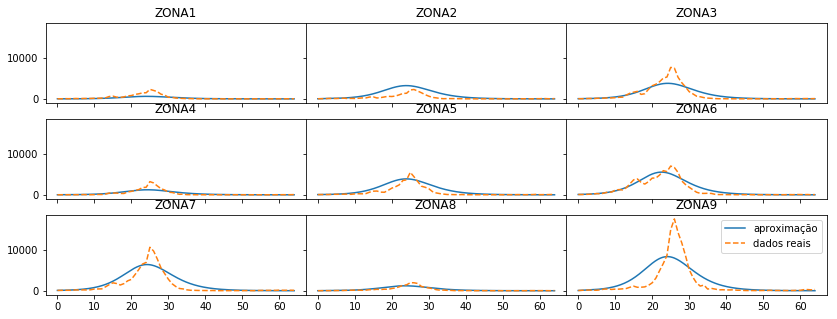

In [17]:
def exibir_resultados(erro, melhor_fit, Casos, str_parametros):
    for i, parametro in enumerate(str_parametros):
        print(f'{parametro} = {melhor_fit[i]}')

    divergencia, S = erro(melhor_fit, retornar_resultado = True)
    print(f'erro = {divergencia}')
    limcima = max(np.max(S), np.max(Casos))+1000

    fig, axs = plt.subplots(3,3, sharex='col', sharey='row',
                            gridspec_kw={'wspace': 0},
                            figsize = (14, 5))
    axs = np.matrix(axs).A1

    for i, area in enumerate(areasAlvo):
        axs[i].plot(ts_continuo, S[i], label = "aproximação")
        axs[i].plot(Casos[i], '--', label = "dados reais")
        axs[i].set_title(area)
        axs[i].set_ylim((-1000, limcima))
    plt.legend()
    plt.show()
exibir_resultados(erro, melhor_fit, Casos, ["βG1", "θG2", "θG3", "θG4", "γ"])

In [18]:
βG1, θG2, θG3, θG4, γ = melhor_fit
βG2 = θG2*βG1; βG3 = θG3*βG1; βG4 = θG4*βG1
β = np.array([βG1, βG1, βG2, βG1, βG2, βG3, βG2, βG1, βG4])

Tentaremos fitar, agora, uma gaussiana para a taixa de infecção.

g = 0.6719845822990055
h = 42.52335527792045
μ = 16.49018141974864
σ = 11.894529957620112
erro = 171.2978636878426


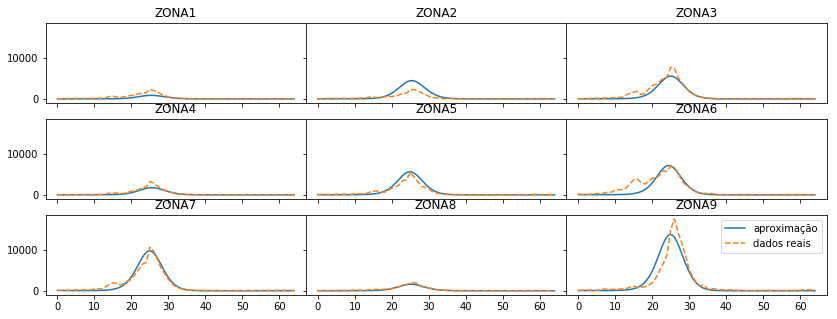

In [19]:
def dSI_dt(SI, t, g, h, μ, σ):
    gaussiana = h*norm.pdf(t, μ, σ)
    β0 = g + gaussiana
    βG2 = g + θG2*gaussiana
    βG3 = g + θG3*gaussiana
    βG4 = g + θG4*gaussiana
    β = np.array([βG1, βG1, βG2, βG1, βG2, βG3, βG2, βG1, βG4])
    S, I = SI[:9], SI[9:]
    L = np.diag(ϕ_@np.diag(β)@I) @ S
    return np.append(-L, L-γ*I)
    
def erro(parametros, retornar_resultado = False):
    sol = odeint(dSI_dt, np.append(N - Casos[:, 0], Casos[:,0]), ts_continuo, args = tuple(parametros))
    S = np.array([sol[:,i] for i in range(9, 18)])
    
    ans = np.linalg.norm(dividir_linhas(S[:, pts_discretos]\
                          - Casos, np.median(Casos, axis=1)), ord = 'fro')
    
    if retornar_resultado:
        ans = (ans, S)
    return ans

malha_de_parametros = [[0, 0.5, 1],
                       [1 + (5-1)*i/3 for i in range(4)],
                       [tf*i/(2*4) for i in range(5)],
                       [1 + (tf-1)*i/3 for i in range(4)]]
chute = encontrar_chute(erro, malha_de_parametros)
melhor_fit = minimize(erro, chute, bounds = [[0, np.inf], [0, np.inf], [0, tf], [0, np.inf]]).x
exibir_resultados(erro, melhor_fit, Casos, ["g", "h", "μ", "σ"])

## Conclusão

Estaremos nos referindo ao nosso estudo sobre o Centro, a Favela e os 4 bairros nobres como Análise 1 e o estudo com as 9 macrozonas como Análise 2.

Percebemos que, como esperado, os valores para $\mu$ que obtemos para a Análise 1 é bem próximo do qual obtemos para a Análise 2. Mais especificamente, ambos estão posicionados sobre a 16º semana epidemiológica desde o início do nosso período de análise, i.e., sobre a primeira semana de fevereiro de 2008. Isso condiz com estudos anteriores que aferiram que o mosquito tem mais facilidade de proliferar em temperaturas mais altas, no verão.

Na Análise 1, nota-se uma progressão contínua quanto a qualidade do fit. No seu estado final, tínhamos que a taxa de infecção no centro era 9.96 vezes maior que nos bairros nobres, enquanto a da favela era apenas 3.41 vezes. Já na Análise 2, no estado final do nosso fit, obtemos que o Grupo 3 era o mais infeccioso, enquanto o Grupo 4, o menos. No entanto, dessa vez não obtemos diferenças tão gritantes entre as taxas de infecção. Uma possível justificativa é: uma vez que as macrozonas analisadas são maiores que os bairros da Análise 1, e essas são reunidas em Grupos ainda maiores, mesmo que uma das subdivisões englobe um ponto no Rio de Janeiro onde o número de casos de dengue é um outlier, esse poderá ser balanceado com o resto da subdivisão.

Podemos ainda analisar nosso fit da matriz $\phi$ na Análise 1, embora esse não seja o foco deste trabalho. Nossas hipóteses levaram a parâmetros que afirmar que cerca de 7% das pessoas de cada uma das áreas trabalham no Centro, 20% das pessoas da Favela trabalham em uma dos bairros nobres e 75% das pessoas de cada um dos bairros nobres trabalha em um outro bairro nobre diferente do qual reside.